In [ ]:
import os #to joint the path
from glob import glob #used to extract images and masks path
from sklearn.model_selection import train_test_split #to split the dataset to train and validation
from tqdm import tqdm #The progress bar
import cv2

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!ls '/content/drive/MyDrive/DATASET/Extracted/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test'

Test001     Test007  Test014_gt  Test020     Test024_gt  Test032
Test002     Test008  Test015	 Test021     Test025	 Test032_gt
Test003     Test009  Test016	 Test021_gt  Test026	 Test033
Test003_gt  Test010  Test017	 Test022     Test027	 Test034
Test004     Test011  Test018	 Test022_gt  Test028	 Test035
Test004_gt  Test012  Test018_gt  Test023     Test029	 Test036
Test005     Test013  Test019	 Test023_gt  Test030	 UCSDped1.m
Test006     Test014  Test019_gt  Test024     Test031	 UCSDped1.m~


In [ ]:
def create_dir(path):
  """ Create a directory """
  if not os.path.exists(path):
    os.makedirs(path)

In [ ]:
create_dir("data/UCSDped1/")

In [ ]:
!cp -r '/content/drive/MyDrive/DATASET/Extracted/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019' '/content/data/UCSDped1'
!cp -r '/content/drive/MyDrive/DATASET/Extracted/UCSD/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test019_gt' '/content/data/UCSDped1'

In [ ]:
dataset_path = '/content/data/UCSDped1'
frames = sorted(glob(f"{dataset_path}/*/*.tif"))
masks = sorted(glob(f"{dataset_path}/*/*.bmp"))
# frames = f"{dataset_path}/*/*.bmp"
# for a in images:
#   print(a)
len(frames), len(masks)

(200, 200)

##Vision Transformer

In [ ]:
%pip install transformers
%pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
import cv2
from PIL import Image
import requests

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')
pretrained_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', output_attentions=True)

/usr/local/lib/python3.9/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [ ]:
import torch
from einops import reduce, rearrange
import numpy as np
import matplotlib.pyplot as plt

ModuleNotFoundError: ignored

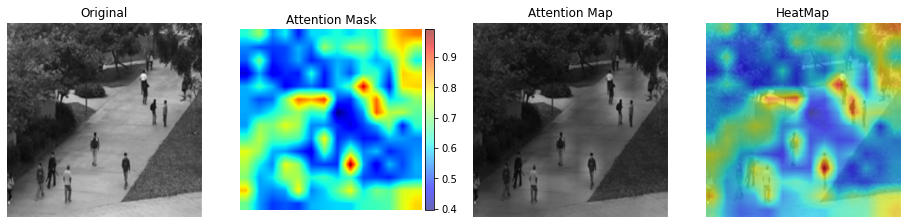

In [ ]:
# urld='/content/126.jpg'
dataset = '/content/data/UCSDped1/Test019/'
dataset = '/content/new_data/valid/frame/UCSDped1_010.jpg'

urld='/content/112.jpg'
# image = Image.open(urld)
# image = Image.open(dataset+"001.tif")
image = Image.open(dataset)

inputs = feature_extractor(images=image, return_tensors="pt")
outputs = pretrained_model(**inputs)
logits = outputs.logits
attentions = outputs.attentions

att_mat = torch.stack(attentions).squeeze(1)

# attention
att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')
im = np.array(image)

residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
#
result_msk = cv2.resize(mask / mask.max(), image.size)
#
mask = cv2.resize(mask / mask.max(), (im.shape[1], im.shape[0]))[..., np.newaxis]
result = (mask * im).astype("uint8")



fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 16))
ax1.axis(False), ax2.axis(False), ax3.axis(False),ax4.axis(False)

alpha=0.3
beta = (1.0 - alpha)


ax1.set_title('Original')
ax2.set_title('Attention Mask')
ax3.set_title('Attention Map')
ax4.set_title('HeatMap')
_ = ax1.imshow(im)
# _ = ax2.imshow(im, alpha = 0.8)
_ = ax2.imshow(mask.squeeze(), alpha = 1,cmap='jet')
_ = ax3.imshow(result)
# _ = ax3.imshow(result_msk, alpha = 1,cmap='jet') #add
_ = ax4.imshow(im, alpha = 0.8)
_ = ax4.imshow(mask.squeeze(), alpha = 0.6,cmap='jet')

from mpl_toolkits.axes_grid1 import make_axes_locatable

divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(_, cax=cax)


In [ ]:
# My Attention Function
def get_attention_map2(img, get_mask=False):
  inputs = feature_extractor(images=img, return_tensors="pt")
  outputs = pretrained_model(**inputs)
  logits = outputs.logits
  attentions = outputs.attentions

  att_mat = torch.stack(attentions).squeeze(1)

  # attention
  att_mat = reduce(att_mat, 'b h len1 len2 -> b len1 len2', 'mean')
  # im = np.array(image)

  residual_att = torch.eye(att_mat.size(1))
  aug_att_mat = att_mat + residual_att
  aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

  # Recursively multiply the weight matrices
  joint_attentions = torch.zeros(aug_att_mat.size())
  joint_attentions[0] = aug_att_mat[0]

  for n in range(1, aug_att_mat.size(0)):
      joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

  # Attention from the output token to the input space.
  v = joint_attentions[-1]
  grid_size = int(np.sqrt(aug_att_mat.size(-1)))
  mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()
  #
  # result_msk = cv2.resize(mask / mask.max(), image.size)

  if get_mask:
    result = cv2.resize(mask / mask.max(), img.size)
  else:
    mask = cv2.resize(mask / mask.max(), img.size)[..., np.newaxis]
    result = (mask * img).astype("uint8")
  #
  return result




In [ ]:
def attmaptoimg(mask,x,save_path):
# def attmaptoimg(x,save_path):
  name=x.split("/")[-1].split(".")[0]
  tmp_att_name = f"{name}.jpg"

  att_path = os.path.join(save_path, tmp_att_name)
  # print(att_path)
  # fig, (ax1) = plt.subplots(ncols=1, figsize=(10, 10))
  fig, (ax1) = plt.subplots()
  ax1.axis(False)
  ax1.imshow(mask, alpha = 1,cmap='jet')
  fig.savefig(att_path,bbox_inches='tight',pad_inches=0)
  plt.close(fig)

In [ ]:
#Convert tif frame to JPG
def tif_to_jpg(images, save_path):
    for idx, x in tqdm(enumerate(images), total=len(images)):
      """Extracting the dir name and image name"""
      dir_name=x.split("/")[-3]
      name=x.split("/")[-1].split(".")[0]

      """Read the image and name"""
      xim=cv2.imread(x, cv2.IMREAD_COLOR)

      tmp_image_name = f"{name}.jpg"

      image_path = os.path.join(save_path, tmp_image_name)

      cv2.imwrite(image_path, xim)

In [ ]:
from google.colab.patches import cv2_imshow

In [ ]:
create_dir("data/UCSDped1/Test019_att")
create_dir("data/UCSDped1/Test019_jpg")
create_dir("data/UCSDped1/Test019_cmb")

In [ ]:
dataset = '/content/data/UCSDped1/Test019'
save_path = '/content/data/UCSDped1/Test019_jpg/'
# frames = sorted(glob(f"{dataset}/*.jpg"))
frames = sorted(glob(f"{dataset}/*.tif"))
# for i in frames:
#   print(i)
len(frames)
tif_to_jpg(frames,save_path)

100%|██████████| 200/200 [00:00<00:00, 683.91it/s]


In [ ]:
# Generate attention map
dataset_jpg = '/content/data/UCSDped1/Test019_jpg'
save_path_att = '/content/data/UCSDped1/Test019_att/'

frames_jpg = sorted(glob(f"{dataset_jpg}/*.jpg"))
# len(frames_jpg)
# idx, x in tqdm(enumerate(images), total=len(images)):
for idx, x in tqdm(enumerate(frames_jpg), total=len(frames_jpg)):
  if idx>180 :
    image = Image.open(x)
    att_map=get_attention_map2(image, True)
    attmaptoimg(att_map,x, save_path_att)
  # attmaptoimg(x, save_path_att)
  # break

  # print(x)

100%|██████████| 200/200 [00:21<00:00,  9.18it/s]


In [ ]:
#Save Attention map to Colab
!cp -r '/content/data/UCSDped1/Test019_att' '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/data/ped1'

In [ ]:
!ls '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/data/ped1'

Test019_att


In [ ]:
#Get Attention map folder from colab
!cp -r '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/data/ped1/Test019_att/' '/content/data/UCSDped1/'

In [ ]:
import numpy as np
from PIL import Image
from numpy import asarray
from google.colab.patches import cv2_imshow

In [ ]:
def combImgAtt(images, attentions, save_path):
    att_path = '/content/data/UCSDped1/Test019_att/'
    for idx, x in tqdm(enumerate(images), total=len(images)):
      """Extracting the dir name and image name"""
      dir_name=x.split("/")[-3]
      name=x.split("/")[-1].split(".")[0]

      print(dir_name)

      dir_name_att=x.split("/")

      x_att = att_path+name+".jpg"

      # print(x)
      # print(x_att)

      """Read the image and name"""
      x1=cv2.imread(x, cv2.IMREAD_COLOR)
      x2=cv2.imread(x_att, cv2.IMREAD_COLOR)
      frm=cv2.resize(x1, (327,217))
      comb=cv2.add(frm,x2)

      tmp_image_name = f"{name}.jpg"

      image_path = os.path.join(save_path, tmp_image_name)

      cv2.imwrite(image_path, comb)
      # break

In [ ]:
dataset_jpg = '/content/data/UCSDped1/Test019_jpg'
dataset_att = '/content/data/UCSDped1/Test019_att'
save_path = '/content/data/UCSDped1/Test019_cmb/'
# frames = sorted(glob(f"{dataset}/*.jpg"))
frames = sorted(glob(f"{dataset_jpg}/*.jpg"))
attentions = sorted(glob(f"{dataset_att}/*.jpg"))
# for i in frames:
#   print(i)
len(frames), len(attentions)
combImgAtt(frames,attentions,save_path)

(200, 200)

In [ ]:
#Save Attention map to Colab
!cp -r '/content/data/UCSDped1/Test019_cmb' '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/data/ped1'

## Test

(217, 327, 3)


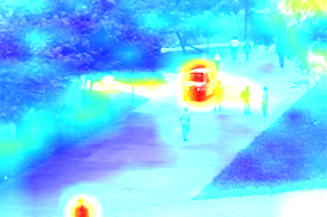

327 217


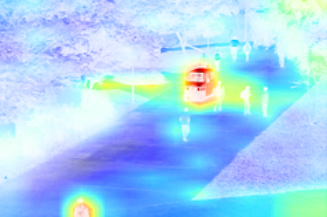

shape require (217, 327, 4)


((217, 327, 3), (217, 327, 3), (217, 327, 3), (217, 327, 6))

In [ ]:

att=cv2.imread('/content/data/UCSDped1/Test019_att/085.jpg')
frm=cv2.imread('/content/data/UCSDped1/Test019_jpg/085.jpg')
(217, 327)
frm2=cv2.resize(frm, (327,217))
comb=cv2.add(frm2,att)
# cv2_imshow(comb)
# att.shape
# frm.shape
print(comb.shape)
np_img = np.array(frm2)
np_att = np.array(att)
# cv2_imshow(np_img)
np_img.shape, np_att.shape
np_comb = np_img + np_att
np_comb.shape
cv2_imshow(comb)

# -----
# load the image and convert into numpy array
attention = Image.open('/content/data/UCSDped1/Test019_att/085.jpg')
frame = Image.open('/content/data/UCSDped1/Test019_jpg/085.jpg')

W, H=attention.size
print(W, H)
newsize  = (327,217,3)

frame2=frame.resize((W, H))
# newsize  = (327,217)
frame2.size, frame.size

numpyFrame = asarray(frame2)
numpyAtt = asarray(attention)


new_np = numpyFrame + numpyAtt

numpyAtt2=numpyAtt
numpyFrame2=numpyFrame
new_np2 = np.append(numpyAtt2,numpyFrame2,axis=2)
# new_np3=np.concatenate((numpyFrame2, numpyAtt2))
new_np2_1 = np.append(att,frm2,axis=2)


# asarray() class is used to convert PIL images into NumPy arrays
# numpydata = asarray(attention)
# numpydata2 = asarray(frame)
# newsize  = (327,217,3)
# numpydata3 = numpydata2.resize(newsize)
cv2_imshow(new_np2_1[:,:,:4])
print("shape require",new_np2_1[:,:,:4].shape)
new_np.shape, numpyAtt2.shape, numpyFrame2.shape, new_np2.shape

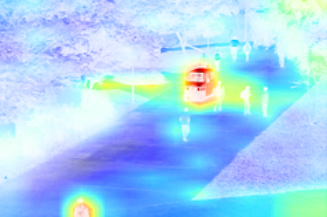

True

In [ ]:
# save
ff=new_np2_1[:,:,:4]
cv2_imshow(ff)
cv2.imwrite("az.jpg", comb)

In [ ]:
new_np_reshape= new_np2.reshape(217, 327, 4)
new_np_reshape.shape

(217, 327, 4)

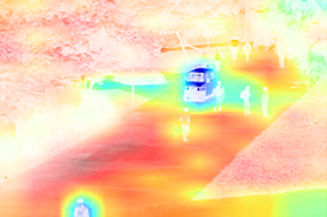

In [ ]:
new_np4 = new_np2[:,:,:4]
cv2_imshow(new_np4)

In [ ]:
import matplotlib.pyplot as plt

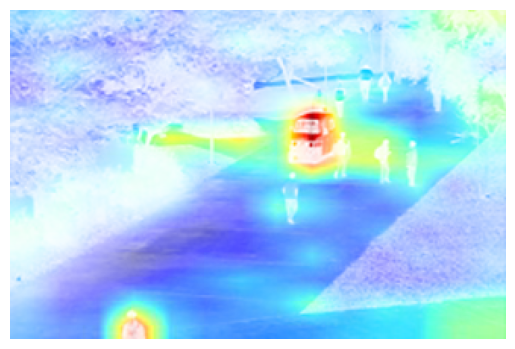

In [ ]:
  fig, (ax1) = plt.subplots()
  ax1.axis(False)
#  ax1.imshow(np_comb)
  ax1.imshow(new_np2[:,:,:4])

##Prepar train and valid dataset

In [ ]:
from sklearn.utils.validation import sp
def load_data(path,split=0.2):
  """ Load frames and masks """
  # frames = sorted(glob(f"{path}/Test019/*.tif"))
  # frames = sorted(glob(f"{path}/Test019_att/*.jpg"))
  frames = sorted(glob(f"{path}/Test019_cmb/*.jpg"))
  masks = sorted(glob(f"{path}/Test019_gt/*.bmp"))
  print("Number of frames : ",len(frames))
  print("Number of masks : ", len(masks))

  """ Split the data """
  split_size = int(len(frames) * split)
  train_x, valid_x = train_test_split(frames, test_size=split_size, random_state=42)
  train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

  return (train_x, train_y), (valid_x, valid_y)

In [ ]:
""" Load tha dataset """
dataset_path = '/content/data/UCSDped1'
(train_x, train_y), (valid_x, valid_y) = load_data(dataset_path,split=0.2)
print("Train: ", len(train_x))
print("Valid: ", len(valid_x))


Number of frames :  200
Number of masks :  200
Train:  160
Valid:  40


In [ ]:
create_dir("new_data/train/frame/")
create_dir("new_data/train/mask/")
create_dir("new_data/valid/frame/")
create_dir("new_data/valid/mask/")

In [ ]:
from albumentations import HorizontalFlip, VerticalFlip, Rotate #Data augmentation

In [ ]:
# , rotate
# Image,
def augment_data(images, masks, save_path, augment=False):
  """ Performing data augmentation """
  H = 512
  W = 512

  for idx, (x,y) in tqdm(enumerate(zip(images, masks)), total=len(images)):
    """Extracting the dir name and image name"""
    dir_name=x.split("/")[-3]
    name=dir_name + "_" + x.split("/")[-1].split(".")[0]
    # print(dir_name, name)
    # print(x,y)

    """Read the image and name"""
    x=cv2.imread(x, cv2.IMREAD_COLOR)
    y=cv2.imread(y, cv2.IMREAD_COLOR)

    if augment== True:
      aug = HorizontalFlip(p=1.0) #p:probability of applying this data augmentation
      augmented = aug(image=x, mask=y)
      x1=augmented["image"]
      y1=augmented["mask"]

      aug = VerticalFlip(p=1)
      augmented = aug(image=x, mask=y)
      x2=augmented["image"]
      y2=augmented["mask"]

      aug = Rotate(limit=45, p=1.0)
      augmented = aug(image=x, mask=y)
      x3=augmented["image"]
      y3=augmented["mask"]

      X=[x, x1, x2, x3]
      Y=[y, y1, y2, y3]

    else:
      X=[x]
      Y=[y]
      # cv2_imshow(x)
      # cv2_imshow(X)
      # print(len(x))
      # print(len(X))


    idx = 0
    for i, m in zip(X, Y):
      i=cv2.resize(i,(W,H))
      m=cv2.resize(m, (W,H))
      m=m/255.0
      m=(m > 0.5)*255

      if len(X) == 1:
        tmp_image_name = f"{name}.jpg"
        tmp_mask_name = f"{name}.jpg"
      else:
        tmp_image_name = f"{name}_{idx}.jpg"
        tmp_mask_name = f"{name}_{idx}.jpg"

      image_path = os.path.join(save_path,"frame/", tmp_image_name)
      mask_path = os.path.join(save_path,"mask/", tmp_mask_name)

      cv2.imwrite(image_path, i)
      cv2.imwrite(mask_path, m)

      idx += 1

    # break


In [ ]:
# augment_data(train_x, train_y,"new_data/train/", augment=True)
augment_data(train_x, train_y,"new_data/train/", augment=False)
augment_data(valid_x, valid_y,"new_data/valid/", augment=False) #we dont apply data augmentation for validation data

100%|██████████| 40/40 [00:01<00:00, 35.81it/s]


##Model U-Net

In [ ]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
#Mpdel:is a model class that take an input image and output mask

In [ ]:
#Create convolution block
# is basacly 2 3 by 3 convolution
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding="same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding="same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  return x

In [ ]:
#Encoder block
def encoder_block(input, num_filter):
  x = conv_block(input, num_filter) #x is skip connection
  p = MaxPool2D((2, 2))(x) # p is a feature for next block
  return x, p

In [ ]:
# def decoder_block(input, skip_features, num_filters):
#Skip connection is basacly features for the encoder layer
# def decoder_block(input, num_filters): #V1 without skip
def decoder_block(input, skip_features, num_filters):
  # print(input.shape)
  x = Conv2DTranspose(num_filters, (2,2), strides=2, padding="same")(input)
  # print(x.shape)
  x = Concatenate()([x, skip_features])
  # print(x.shape)
  x = conv_block(x, num_filters)
  return x

In [ ]:
def build_unet(input_shape):
  inputs = Input(input_shape)
#The encoder part
  s1, p1 = encoder_block(inputs, 64) #64:number of filters
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)
#the rsolution decreases and the number of filter increases, thats the rule
#Bottle neck part (its conv block, not Pool there)
  b1 = conv_block(p4, 1024)

#The decoder part
  # d1 = decoder_block(b1,512) V1
  d1 = decoder_block(b1,s4, 512) #V2:add skip connection

  # print(p1.shape, p2.shape, p3.shape, p4.shape)
  # print(s1.shape, s2.shape, s3.shape, s4.shape)
  #la last shape(s4) is the same shape required
  d2 = decoder_block(d1,s3, 256)
  d3 = decoder_block(d2,s2, 128)
  d4 = decoder_block(d3,s1, 64)
#in the decoder part the rsolution increases and the number of filter decreases

  outputs = Conv2D(1,1, padding="same", activation="sigmoid")(d4)
  #1 : number of filters
  #1 : number of colon size
  #one bcz we have one classe only (mask)

  model = Model(inputs, outputs, name="U-Net")
  return model


In [ ]:
#Main
input_shape = (512,512,3)
# input_shape = (512,512,4)
# build_unet(input_shape)
#time : 33:04
model = build_unet(input_shape)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 512, 512, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 512, 512, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
##Trainig dataset
from os.path import ismount
import os
# os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import cv2
from glob import glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall, Precision
# from model import build_unet #File
# from metrics import dice_loss, dice_coef,iou #File

In [ ]:
H = 512
W = 512
def shuffling(x,y):
  x,y = shuffle(x,y, random_state=42)
  return x,y

def load_new_data(path):
  x = sorted(glob(os.path.join(path,"frame","*.jpg")))
  y = sorted(glob(os.path.join(path,"mask","*.jpg")))
  return x,y

def read_image(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_COLOR)
  # x = cv2.resize(x, (W, H))
  x = x/255.0
  x = x.astype(np.float32)
  return x

def read_mask(path):
  path = path.decode()
  x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
  # x = cv2.resize(x, (W, H))
  x = x/255.0
  x = x > 0.5
  x = x.astype(np.float32)
  x = np.expand_dims(x, axis=-1)
  return x

#Build dataset piplin
def tf_parse(x,y):
  def _parse(x,y):
    x = read_image(x)
    y = read_mask(y)
    return x,y

  x,y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
  x.set_shape([H, W, 3])
  y.set_shape([H, W, 1])
  return x,y

def tf_dataset(x,y, batch=8):
  #x,y : list of images and masks path
  dataset = tf.data.Dataset.from_tensor_slices((x,y))
  dataset = dataset.map(tf_parse)
  dataset = dataset.batch(batch)
  dataset = dataset.prefetch(10)
  return dataset


In [ ]:
#Main
"""Seeding"""
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing files"""
create_dir("files")


""" Hyperparameters """
batch_size = 2
lr = 1e-4
num_epochs = 10
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files","data.csv")

"""Dataset"""
dataset_path = os.path.join("new_data")
train_path = os.path.join(dataset_path, "train")
valid_path = os.path.join(dataset_path, "valid")

train_x, train_y = load_new_data(train_path)
train_x, train_y = shuffling(train_x, train_y)
valid_x, valid_y = load_new_data(valid_path)

print(f"Train: {len(train_x)} - {len(train_y)} ")
print(f"Valid: {len(valid_x)} - {len(valid_y)} ")



Train: 160 - 160 
Valid: 40 - 40 


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

##Metrics

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import  backend as k

In [ ]:
def iou(y_true, y_pred):
  def f(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    union = y_true.sum() + y_pred.sum() - intersection
    x = (intersection + 1e-15) / (union + 1e-15)
    x = x.astype(np.float32)
    return x
  return tf.numpy_function(f, [y_true, y_pred], tf.float32)

smooth = 1e-15

def dice_coef(y_true, y_pred):
  y_true = tf.keras.layers.Flatten()(y_true)
  y_pred = tf.keras.layers.Flatten()(y_pred)
  intersection = tf.reduce_sum(y_true * y_pred)
  return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)+smooth)

def dice_loss(y_true, y_pred):
  return 1.0 - dice_coef(y_true, y_pred)

##training the model

In [ ]:
H = 512
W = 512
input_shape = (H,W,3)
model = build_unet(input_shape)
metrics = [dice_coef, iou, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=metrics)

#This callback use will training
callbacks = [
             ModelCheckpoint(model_path, verbose=1,save_best_only=True),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=10, min_lr=1e-7,verbose=1),
             CSVLogger(csv_path),
             TensorBoard(),
             EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=False)
             #if we achieve 50 epoches and the val_loss doesnt dercease stop training
             ]

model.fit(
    train_dataset,
    epochs=num_epochs,
    validation_data=valid_dataset,
    # steps_per_epoch=train_steps,
    # validation_steps=valid_steps,
    callbacks=callbacks,
    shuffle=False
)


Epoch 1/10
80/80 [==============================] - ETA: 0s - loss: 0.9581 - dice_coef: 0.0419 - iou: 0.0221 - recall: 0.9411 - precision: 0.0367
Epoch 1: val_loss improved from inf to 0.98764, saving model to files/model.h5
80/80 [==============================] - 84s 563ms/step - loss: 0.9581 - dice_coef: 0.0419 - iou: 0.0221 - recall: 0.9411 - precision: 0.0367 - val_loss: 0.9876 - val_dice_coef: 0.0124 - val_iou: 0.0063 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/10
80/80 [==============================] - ETA: 0s - loss: 0.9155 - dice_coef: 0.0845 - iou: 0.0462 - recall: 0.9415 - precision: 0.1465
Epoch 2: val_loss did not improve from 0.98764
80/80 [==============================] - 44s 551ms/step - loss: 0.9155 - dice_coef: 0.0845 - iou: 0.0462 - recall: 0.9415 - precision: 0.1465 - val_loss: 0.9882 - val_dice_coef: 0.0118 - val_iou: 0.0060 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/10
80/80 [==================

In [ ]:
!cp -r '/content/files' '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/Model_3'
!cp -r '/content/logs' '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/Model_3'

##Evaluation

In [ ]:
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score,recall_score

In [ ]:
"""Seeding"""
np.random.seed(42)
tf.random.set_seed(42)

"""Directory for storing results"""
create_dir("results")

"""Loading model"""
with CustomObjectScope({'iou':iou, 'dice_coef':dice_coef, 'dice_loss':dice_loss}):
  model = tf.keras.models.load_model("files/model.h5")
  model.summary()


Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_18 (BatchN  (None, 512, 512, 64  256        ['conv2d_19[0][0]']              
 ormalization)                  )                                                             

In [ ]:
"""Load the dataset"""
test_x = sorted(glob(os.path.join("new_data", "valid", "frame","*")))
test_y = sorted(glob(os.path.join("new_data", "valid", "mask","*")))
print(f"Test: {len(test_x)} - {len(test_y)} ")


Test: 40 - 40 


In [ ]:
#Function
def save_results(image, mask, y_pred, save_image_path):
  ## i - m - y
  line = np.ones((H, 10, 3)) * 128

  """ Mask """
  mask = np.expand_dims(mask, axis=-1) ##(512,512,1)
  mask = np.concatenate([mask,mask,mask], axis=-1) #(512,512,3)

  """ Predicted Mask """
  y_pred = np.expand_dims(y_pred, axis=-1) ##(512,512,1)
  y_pred = np.concatenate([y_pred, y_pred, y_pred], axis=-1) #(512,512,3)
  y_pred = y_pred * 255

  cat_images = np.concatenate([image, line, mask, line, y_pred], axis=1)
  cv2.imwrite(save_image_path, cat_images)


In [ ]:
import pandas as pd
""" Evaluation and Prediction """
SCORE = []
for x,y in tqdm(zip(test_x,test_y), total=len(test_x)):
  """Extract the name"""
  name = x.split("/")[-1].split(".")[0]
  print(name)

  """Reading the image"""
  image = cv2.imread(x, cv2.IMREAD_COLOR)
  x = image/255.0
  x = np.expand_dims(x, axis=0) #bcz the data is a batch format

  """Reading the mask"""
  mask = cv2.imread(y, cv2.IMREAD_GRAYSCALE)
  y = mask/255.0
  y = y > 0.5
  y = y.astype(np.int32)

  """Prediction"""
  y_pred = model.predict(x)[0]
  y_pred = np.squeeze(y_pred, axis=-1)
  # print(y_pred.shape)
  y_pred = y_pred > 0.5
  y_pred = y_pred.astype(np.int32)

  """Saving the prediction"""
  save_image_path=f"results/{name}.png"
  save_results(image, mask, y_pred, save_image_path)

  """Flatten the array"""
  y = y.flatten()
  y_pred = y_pred.flatten()

  """Calculating the metrics values"""
  acc_value = accuracy_score(y, y_pred)
  f1_value = f1_score(y, y_pred, labels=[0,1], average="binary", zero_division=1)
  jac_value = jaccard_score(y, y_pred, labels=[0,1], average="binary", zero_division=1)
  recall_value = recall_score(y, y_pred, labels=[0, 1], average="binary", zero_division=1)
  precision_value = precision_score(y,y_pred, labels=[0,1], average="binary", zero_division=1)
  SCORE.append([name, acc_value, f1_value, jac_value, recall_value, precision_value])


"""Metrics value"""
score = [s[1:]for s in SCORE]
score = np.mean(score, axis=0)
print(f"Accuracy:{score[0]:0.5f}")
print(f"F1:{score[1]:0.5f}")
print(f"Jaccard:{score[2]:0.5f}")
print(f"Recall:{score[3]:0.5f}")
print(f"Precision:{score[4]:0.5f}")


df = pd.DataFrame(SCORE, columns=["Image", "Accuracy", "F1", "Jaccard", "Recall", "Precision"])
df.to_csv("files/score.csv")


  0%|          | 0/40 [00:00<?, ?it/s]

UCSDped1_010
1/1 [==============================] - 3s 3s/step


  2%|▎         | 1/40 [00:06<03:57,  6.08s/it]

UCSDped1_016
1/1 [==============================] - 0s 38ms/step


  5%|▌         | 2/40 [00:06<01:50,  2.91s/it]

UCSDped1_017
1/1 [==============================] - 0s 40ms/step


  8%|▊         | 3/40 [00:07<01:09,  1.87s/it]

UCSDped1_019
1/1 [==============================] - 0s 38ms/step


 10%|█         | 4/40 [00:07<00:47,  1.33s/it]

UCSDped1_031
1/1 [==============================] - 0s 25ms/step


 12%|█▎        | 5/40 [00:08<00:35,  1.01s/it]

UCSDped1_046
1/1 [==============================] - 0s 24ms/step


 15%|█▌        | 6/40 [00:08<00:27,  1.24it/s]

UCSDped1_056
1/1 [==============================] - 0s 26ms/step


 18%|█▊        | 7/40 [00:09<00:22,  1.49it/s]

UCSDped1_057
1/1 [==============================] - 0s 23ms/step


 20%|██        | 8/40 [00:09<00:18,  1.72it/s]

UCSDped1_061
1/1 [==============================] - 0s 24ms/step


 22%|██▎       | 9/40 [00:09<00:16,  1.86it/s]

UCSDped1_066
1/1 [==============================] - 0s 26ms/step


 25%|██▌       | 10/40 [00:10<00:14,  2.04it/s]

UCSDped1_067
1/1 [==============================] - 0s 23ms/step


 28%|██▊       | 11/40 [00:10<00:13,  2.10it/s]

UCSDped1_068
1/1 [==============================] - 0s 28ms/step


 30%|███       | 12/40 [00:11<00:12,  2.21it/s]

UCSDped1_069
1/1 [==============================] - 0s 23ms/step


 32%|███▎      | 13/40 [00:11<00:11,  2.28it/s]

UCSDped1_070
1/1 [==============================] - 0s 23ms/step


 35%|███▌      | 14/40 [00:12<00:11,  2.26it/s]

UCSDped1_076
1/1 [==============================] - 0s 23ms/step


 38%|███▊      | 15/40 [00:12<00:10,  2.29it/s]

UCSDped1_077
1/1 [==============================] - 0s 23ms/step


 40%|████      | 16/40 [00:12<00:10,  2.34it/s]

UCSDped1_079
1/1 [==============================] - 0s 22ms/step


 42%|████▎     | 17/40 [00:13<00:09,  2.40it/s]

UCSDped1_083
1/1 [==============================] - 0s 38ms/step


 45%|████▌     | 18/40 [00:13<00:09,  2.41it/s]

UCSDped1_085
1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 19/40 [00:14<00:08,  2.45it/s]

UCSDped1_094
1/1 [==============================] - 0s 24ms/step


 50%|█████     | 20/40 [00:14<00:08,  2.46it/s]

UCSDped1_096
1/1 [==============================] - 0s 23ms/step


 52%|█████▎    | 21/40 [00:14<00:07,  2.44it/s]

UCSDped1_105
1/1 [==============================] - 0s 23ms/step


 55%|█████▌    | 22/40 [00:15<00:07,  2.45it/s]

UCSDped1_116
1/1 [==============================] - 0s 23ms/step


 57%|█████▊    | 23/40 [00:15<00:06,  2.48it/s]

UCSDped1_125
1/1 [==============================] - 0s 23ms/step


 60%|██████    | 24/40 [00:16<00:06,  2.50it/s]

UCSDped1_126
1/1 [==============================] - 0s 25ms/step


 62%|██████▎   | 25/40 [00:16<00:05,  2.53it/s]

UCSDped1_129
1/1 [==============================] - 0s 23ms/step


 65%|██████▌   | 26/40 [00:16<00:05,  2.42it/s]

UCSDped1_133
1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 27/40 [00:17<00:05,  2.45it/s]

UCSDped1_136
1/1 [==============================] - 0s 22ms/step


 70%|███████   | 28/40 [00:17<00:04,  2.46it/s]

UCSDped1_138
1/1 [==============================] - 0s 33ms/step


 72%|███████▎  | 29/40 [00:18<00:05,  2.12it/s]

UCSDped1_149
1/1 [==============================] - 0s 32ms/step


 75%|███████▌  | 30/40 [00:19<00:05,  1.87it/s]

UCSDped1_151
1/1 [==============================] - 0s 34ms/step


 78%|███████▊  | 31/40 [00:19<00:05,  1.74it/s]

UCSDped1_153
1/1 [==============================] - 0s 36ms/step


 80%|████████  | 32/40 [00:20<00:04,  1.65it/s]

UCSDped1_159
1/1 [==============================] - 0s 32ms/step


 82%|████████▎ | 33/40 [00:21<00:04,  1.60it/s]

UCSDped1_165
1/1 [==============================] - 0s 35ms/step


 85%|████████▌ | 34/40 [00:21<00:03,  1.60it/s]

UCSDped1_166
1/1 [==============================] - 0s 28ms/step


 88%|████████▊ | 35/40 [00:22<00:02,  1.74it/s]

UCSDped1_171
1/1 [==============================] - 0s 24ms/step


 90%|█████████ | 36/40 [00:22<00:02,  1.92it/s]

UCSDped1_175
1/1 [==============================] - 0s 29ms/step


 92%|█████████▎| 37/40 [00:22<00:01,  2.06it/s]

UCSDped1_178
1/1 [==============================] - 0s 26ms/step


 95%|█████████▌| 38/40 [00:23<00:00,  2.20it/s]

UCSDped1_183
1/1 [==============================] - 0s 23ms/step


 98%|█████████▊| 39/40 [00:23<00:00,  2.31it/s]

UCSDped1_187
1/1 [==============================] - 0s 24ms/step


100%|██████████| 40/40 [00:24<00:00,  1.66it/s]

Accuracy:0.99623
F1:0.76990
Jaccard:0.70551
Recall:0.96149
Precision:0.74236


In [ ]:
#Save results to Colab
!cp -r '/content/results' '/content/drive/MyDrive/Colab Notebooks/Implement research paper/U-Net/ViT-UNet/Model_3'